In [43]:
#importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

data_location='C:/Users/pande/OneDrive/Desktop/Lead Scoring Assignment/Leads.csv'

In [2]:
#importing the dataset, checking the shape and viewing it.
df=pd.read_csv(data_location)
print(df.shape)
df.head()

(9240, 37)


,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


# DATA CLEANING

In [3]:
#Removing Lead Number and Prospect ID as they don't add any value to the analysis
df.drop(['Prospect ID','Lead Number'],inplace=True,axis=1)

In [4]:
#Checking unique values in the columns
df.nunique()

Lead Origin                                         5
Lead Source                                        21
Do Not Email                                        2
Do Not Call                                         2
Converted                                           2
TotalVisits                                        41
Total Time Spent on Website                      1731
Page Views Per Visit                              114
Last Activity                                      17
Country                                            38
Specialization                                     19
How did you hear about X Education                 10
What is your current occupation                     6
What matters most to you in choosing a course       3
Search                                              2
Magazine                                            1
Newspaper Article                                   2
X Education Forums                                  2
Newspaper                   

There are few features with only one unique value. There are chances that if they have missing values, the availablity and non-availablity of data may hold a meaning. Otherwise the columns will be meaningless.

In [5]:
#Searching for the features with one unique value and no missing values
(df.nunique()==1) & (df.isna().sum()==0)

Lead Origin                                      False
Lead Source                                      False
Do Not Email                                     False
Do Not Call                                      False
Converted                                        False
TotalVisits                                      False
Total Time Spent on Website                      False
Page Views Per Visit                             False
Last Activity                                    False
Country                                          False
Specialization                                   False
How did you hear about X Education               False
What is your current occupation                  False
What matters most to you in choosing a course    False
Search                                           False
Magazine                                          True
Newspaper Article                                False
X Education Forums                               False
Newspaper 

In [6]:
#Dropping the columns with single unique value and no 
df.drop(['Magazine','Receive More Updates About Our Courses',
         'Update me on Supply Chain Content','Get updates on DM Content',
         'I agree to pay the amount through cheque'],axis=1,inplace=True)

In [7]:
#Figuring out categorical and numerical values

numerical=df.select_dtypes(include='number')
categorical=df.select_dtypes(exclude='number')

print("Numerical:",numerical.shape[1])
print("Categorical:",categorical.shape[1])

Numerical: 6
Categorical: 24


In [8]:
#Checking the number of null values in the dataset
cols_null=[(col,np.round(df[col].isna().sum()*100/df.shape[0],2)) for col in df.columns if df[col].isna().sum()>0]
cols_null=pd.DataFrame(cols_null,).rename({0:'Feature',1:'%Missing'},axis=1)
cols_null

,Feature,%Missing
0,Lead Source,0.39
1,TotalVisits,1.48
2,Page Views Per Visit,1.48
3,Last Activity,1.11
4,Country,26.63
5,Specialization,15.56
6,How did you hear about X Education,23.89
7,What is your current occupation,29.11
8,What matters most to you in choosing a course,29.32
9,Tags,36.29


There are no features with missing values high enough to drop any columns

In [9]:
#Replacing the null values and 'Select' as a parameter in categorical features with NA. 
for col in categorical.columns:
    if df[col].isna().sum()>0:
        df[col]=df[col].fillna('NA')
    df[col]=np.where(df[col]=='Select','NA',df[col])

In [10]:
#Replacing missing values with their respective median values
for col in numerical.columns:
    if df[col].isna().sum()>0:
        df[col]=df[col].fillna(df[col].median())

In [12]:
print("Total numbers of null values left in the dataset:",df.isna().sum().sum())

Total numbers of null values left in the dataset: 0


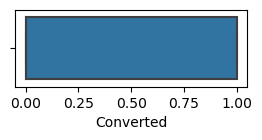

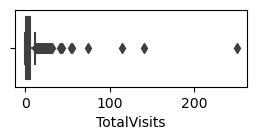

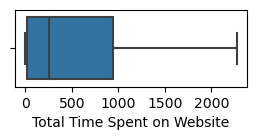

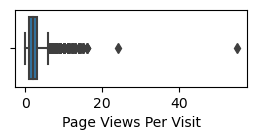

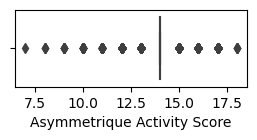

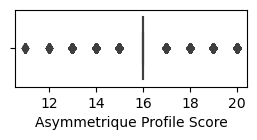

In [13]:
#Checking for outliers
for col in numerical.columns:
    fig=plt.figure(figsize=(3,1))
    sns.boxplot(df[col])
    plt.show()

"Page per visit" and "Total Visits" have outliers which need to be attended. "Asymmetrique" features also have outliers but since they consist of discrete values, not attending their outliers.

In [14]:
#Replacing the outliers with the respective medians
for col in ["Page Views Per Visit" , "TotalVisits"]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    median = df[col].median()
    df[col].loc[df[col] < lower_bound] = median
    df[col].loc[df[col] > upper_bound] = median

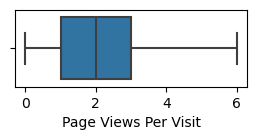

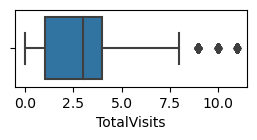

In [15]:
#Confirming the change of values
for col in ["Page Views Per Visit" , "TotalVisits"]:
    fig=plt.figure(figsize=(3,1))
    sns.boxplot(df[col])
    plt.show()

<AxesSubplot:>

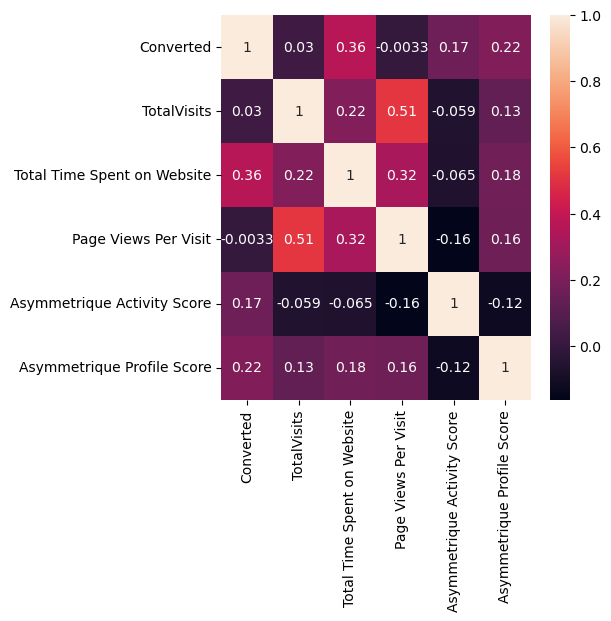

In [16]:
fig=plt.figure(figsize=(5,5))
sns.heatmap(data=numerical.corr(),annot=True)

Now checking the unique values in respective columns to eliminate any repetition, if present

In [21]:
def show_unique(feature):
    print(df[feature].unique())
#Some words are present with same implication but different strings. Fixing the variations
def replace_string(feature, string1, string2):
    df[feature]=np.where(df[feature]==string1,string2,df[feature])

In [22]:
show_unique('Lead Source')

['Olark Chat' 'Organic Search' 'Direct Traffic' 'Google' 'Referral Sites'
 'Welingak Website' 'Reference' 'Facebook' 'NA' 'blog' 'Pay per Click Ads'
 'bing' 'Social Media' 'WeLearn' 'Click2call' 'Live Chat'
 'welearnblog_Home' 'youtubechannel' 'testone' 'Press_Release' 'NC_EDM']


In [23]:
replace_string('Lead Source', 'google','Google')
replace_string('Lead Source','welearn_home','WeLearn')

In [24]:
show_unique('Last Activity')

['Page Visited on Website' 'Email Opened' 'Unreachable'
 'Converted to Lead' 'Olark Chat Conversation' 'Email Bounced'
 'Email Link Clicked' 'Form Submitted on Website' 'Unsubscribed'
 'Had a Phone Conversation' 'View in browser link Clicked' 'NA'
 'Approached upfront' 'SMS Sent' 'Visited Booth in Tradeshow'
 'Resubscribed to emails' 'Email Received' 'Email Marked Spam']


In [25]:
show_unique('Country')

['NA' 'India' 'Russia' 'Kuwait' 'Oman' 'United Arab Emirates'
 'United States' 'Australia' 'United Kingdom' 'Bahrain' 'Ghana'
 'Singapore' 'Qatar' 'Saudi Arabia' 'Belgium' 'France' 'Sri Lanka' 'China'
 'Canada' 'Netherlands' 'Sweden' 'Nigeria' 'Hong Kong' 'Germany'
 'Asia/Pacific Region' 'Uganda' 'Kenya' 'Italy' 'South Africa' 'Tanzania'
 'unknown' 'Malaysia' 'Liberia' 'Switzerland' 'Denmark' 'Philippines'
 'Bangladesh' 'Vietnam' 'Indonesia']


In [26]:
replace_string('Country','unknown','NA')

In [27]:
show_unique('Tags')

['Interested in other courses' 'Ringing'
 'Will revert after reading the email' 'NA' 'Lost to EINS'
 'In confusion whether part time or DLP' 'Busy' 'switched off'
 'in touch with EINS' 'Already a student' 'Diploma holder (Not Eligible)'
 'Graduation in progress' 'Closed by Horizzon' 'number not provided'
 'opp hangup' 'Not doing further education' 'invalid number'
 'wrong number given' 'Interested  in full time MBA' 'Still Thinking'
 'Lost to Others' 'Shall take in the next coming month' 'Lateral student'
 'Interested in Next batch' 'Recognition issue (DEC approval)'
 'Want to take admission but has financial problems'
 'University not recognized']


# Analyzing the Trends

# Preparing the data for the model

TotalVisits and Pages Views Per Visit show a comparitively high correlation.

In [30]:
for col in categorical.columns:
    dummies = pd.get_dummies(df[col],prefix_sep='_',prefix=col,drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df.drop(col,axis=1,inplace=True)
df.shape

KeyError: 'Lead Origin'

In [31]:
target=df['Converted']
df.drop('Converted',axis=1,inplace=True)

KeyError: 'Converted'

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df,target, test_size=0.2, random_state=42)

In [33]:
scaler = StandardScaler()
scaled_X=scaler.fit_transform(X_train)

scaled_X_df=pd.DataFrame(scaled_X, index=X_train.index, columns=X_train.columns)
scaled_X_df

In [34]:
estimator=LogisticRegression()
rfe = RFE(estimator, n_features_to_select=30)

In [35]:
rfe.fit(X_train,y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=30)

In the next cell, the columns were dropped after checking the VIF scores

In [36]:
X_train_temp=X_train[X_train.columns[rfe.support_]]
X_test_temp=X_test[X_train.columns[rfe.support_]]

X_train_temp.drop('What matters most to you in choosing a course_NA',axis=1,inplace=True)
X_train_temp.drop('Lead Source_Reference',axis=1,inplace=True)

X_test_temp.drop('What matters most to you in choosing a course_NA',axis=1,inplace=True)
X_test_temp.drop('Lead Source_Reference',axis=1,inplace=True)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_df=pd.DataFrame()
for i in range(X_train_temp.shape[1]):
    X = X_train_temp.values
    y =y_train.values
    vif = variance_inflation_factor(X, i)
    vif_df=vif_df.append({'feature': X_train_temp.columns[i], 'vif': vif}, ignore_index=True)
vif_df

,feature,vif
0,Lead Origin_Lead Add Form,0.088511
1,Lead Source_Facebook,1.017145
2,Lead Source_Welingak Website,1.322941
3,Do Not Email_Yes,0.131207
4,Last Activity_Converted to Lead,0.338506
5,Last Activity_Olark Chat Conversation,0.036521
6,Last Activity_SMS Sent,0.407192
7,What is your current occupation_NA,0.263549
8,Tags_Busy,1.103072
9,Tags_Closed by Horizzon,0.107747


In [39]:
estimator.fit(X_train_temp,y_train)

LogisticRegression()

In [40]:
probabilities=estimator.predict_proba(X_test_temp)
new_threshold = 0.4
y_pred = np.where(probabilities[:, 1] > new_threshold, 1, 0)

In [41]:
pd.Series(y_pred).value_counts()

0    1104
1     744
dtype: int64

In [44]:
# Calculate performance metrics


cm = confusion_matrix(y_test, y_pred)

tp = cm[0, 0]
tn = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = 2 * precision * recall / (precision + recall)

# Print confusion matrix and performance metrics
print("Confusion Matrix:")
print(cm)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall (Sensitivity): {:.2f}".format(recall))
print("Specificity: {:.2f}".format(specificity))
print("F1 Score: {:.2f}".format(f1_score))

Confusion Matrix:
[[1040   67]
 [  64  677]]
Accuracy: 0.93
Precision: 0.94
Recall (Sensitivity): 0.94
Specificity: 0.91
F1 Score: 0.94


As per the business scenario here, Senstivity is a more relevant metric here. For this model the senstivity comes out to be ~0.94

In [45]:
sns.heatmap(probabilities[:, 1]*100)

IndexError: Inconsistent shape between the condition and the input (got (1848, 1) and (1848,))

In [213]:
(probabilities[:, 1]>0.5).sum()

728